In [232]:
%matplotlib inline

In [267]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt    


from graph_tool import load_graph_from_csv, load_graph, GraphView
from graph_tool.topology import label_components, label_largest_component
from collections import Counter, OrderedDict
from tqdm import tqdm


In [295]:
dataset = 'digg'
min_cascade_size = 1000

In [283]:
# g = load_graph_from_csv('data/{}/edges.csv'.format(dataset), csv_options={'delimiter': '\t', 'quotechar': '"'})
g = load_graph('data/{}/graph.gt'.format(dataset))

In [284]:
g.num_vertices(), g.num_edges()

(336225, 1731658)

In [285]:
cs = pd.read_csv('data/{}/cascades.csv'.format(dataset), sep='\t')


In [286]:
c_size = cs[['u', 'c']].groupby('c').count().rename(
    columns={'u': 'size'}
).sort_values(
    by='size',
    ascending=False
)

In [288]:
c_size.head(3)

,size
c,
714,24099
1123,8521
502,8492


In [289]:
def get_subgraph(c_nodes):    
    subg_filt = np.zeros(g.num_vertices())
    subg_filt[c_nodes] = 1    
    
    c = GraphView(g, directed=False, vfilt=subg_filt)
    return c

In [290]:
def cc_stat(c):    
    comp, hist = label_components(c)
    comp_sizes = Counter(comp.a[c_nodes])
    return OrderedDict(
        [('size',  len(c_nodes)), 
         ('top_cc_sizes', [v for _, v in comp_sizes.most_common(5)]),
         ('largest_cc_fraction', hist.max() / hist.sum())]
    )


In [291]:
def cut_stat(subg, g_deg, prefix=''):    
    subg_deg = subg.degree_property_map(deg='out')
    total_deg = sum(g_deg[v] for v in subg.vertices())
    internal_deg = subg.num_edges()  # directed, don't x2
    cut = total_deg - internal_deg
    cut_per_node = cut / subg.num_vertices()
    return OrderedDict([        
            (prefix + 'cut', cut), 
            (prefix + 'cut_per_node', cut_per_node)]
        )

In [301]:
print('avg_degree', g.num_edges() / g.num_vertices())
lcc = GraphView(g, directed=False, vfilt=label_largest_component(g))
print('avg_degree in lcc', lcc.num_edges() / lcc.num_vertices())

avg_degree 5.1502951892334
avg_degree in lcc 6.574506002164527


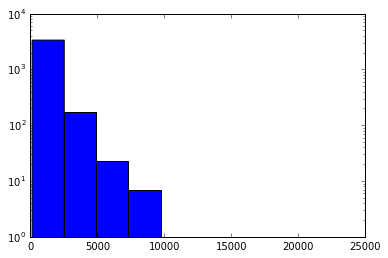

In [293]:
_ = plt.hist(c_size['size'].as_matrix(), log=True) 


In [296]:
c_size_filtered = c_size[c_size['size'] > min_cascade_size]
print('#large cascades: ', c_size_filtered.shape[0])

#large cascades:  759


In [300]:
stat_list = []
g_deg = g.degree_property_map(deg='out')
for cid in tqdm(c_size_filtered.index):
    c_nodes = cs[cs['c'] == cid]['u'].tolist()
    subg = get_subgraph(c_nodes)
    largest_cc = GraphView(subg, directed=False, vfilt=label_largest_component(subg))
    
    stat = cc_stat(subg)
    stat.update(cut_stat(subg, g_deg))
    stat.update(cut_stat(largest_cc, g_deg, 'lcc_'))
    stat_list.append(stat)

100%|██████████| 759/759 [01:58<00:00,  8.33it/s]


In [302]:
stat_df = pd.DataFrame.from_records(stat_list)

In [303]:
stat_df.to_pickle('result/{}.pkl'.format(dataset))

In [306]:
stat_df.sort_values(by='largest_cc_fraction', ascending=False)

,size,top_cc_sizes,largest_cc_fraction,cut,cut_per_node,lcc_cut,lcc_cut_per_node
298,1974,"[1013, 5, 2, 2, 2]",0.514213,167234,84.890355,160588,158.527147
725,1049,"[515, 12, 2, 2, 1]",0.496146,169797,163.580925,166032,322.392233
731,1040,"[490, 3, 2, 2, 2]",0.471607,149795,144.172281,146372,298.718367
693,1094,"[512, 3, 2, 2, 2]",0.468864,143758,131.646520,140889,275.173828
674,1135,"[506, 8, 2, 2, 2]",0.448582,170177,150.866135,165634,327.339921
99,3284,"[1397, 7, 3, 2, 2]",0.426174,186348,56.848078,176888,126.619900
11,6319,"[2627, 10, 4, 4, 3]",0.416323,188985,29.950079,174073,66.263038
727,1048,"[433, 8, 2, 2, 2]",0.415946,171008,164.272815,166580,384.711316
591,1267,"[515, 7, 1, 1, 1]",0.408406,158970,126.066614,154331,299.671845
707,1079,"[437, 7, 2, 2, 2]",0.407269,74977,69.876048,69182,158.311213
